In [1]:
import pandas as pd
import re
from ast import literal_eval

import nltk
nltk.download('punkt')
nltk.download("stopwords")
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
from nltk.tag import pos_tag

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Shivarjun\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Shivarjun\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Shivarjun\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
#user_tweets = pd.read_csv(r".\Data\user_tweets.csv")
mentions_tweets = pd.read_csv(r"mentions_w_urls.csv",converters={"complete_urls": literal_eval, "about": literal_eval})
mentions_tweets = mentions_tweets[['original_text','text','urls','mentions','RT','complete_urls','about']]
display(mentions_tweets.head())

,original_text,text,urls,mentions,RT,complete_urls,about
0,@JohnMil80462729 @1am_Adriana @FoxNews Typical...,Typically when a report comes out regarding a ...,['https://t.co/cHIR7suctA'],"['@JohnMil80462729', '@1am_Adriana', '@FoxNews']",[],[https://twitter.com/i/web/status/144594161495...,[]
1,Despite “news” advertised in past several week...,Despite “news” advertised in past several week...,['https://t.co/u0P6lUvgUz'],"['@FoxNews', '@Newsmax']",[],[https://twitter.com/i/web/status/144594097749...,[]
2,RT @FoxNews: Hundreds of Michigan healthcare w...,RT: Hundreds of Michigan healthcare workers qu...,['https://t.co/dvG2rIlyIL'],['@FoxNews'],['@FoxNews'],[https://www.foxnews.com/us/mass-exodus-hundre...,[mass exodus hundreds of detroit healthcare wo...
3,RT @lpackard: .@FoxNews has undermined vaccine...,RT: .has undermined vaccines nearly every day ...,[],"['@lpackard', '@FoxNews']",['@lpackard'],[],[]
4,"@FoxNews Who cares, 99% of current covid deat...","Who cares, 99% of current covid deaths are ri...",[],['@FoxNews'],[],[],[]


### Clean Up Code

In [3]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

mentions_tweets['sc'] = mentions_tweets['text'].apply(lambda review: sid.polarity_scores(review)['compound'])

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Shivarjun\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [4]:
import string

def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

stop = stopwords.words('english') + ['rt','amp']#,'covid','vaccine'] 
mentions_tweets['text']  = mentions_tweets['text'].map(clean_text)
mentions_tweets['tokens'] = mentions_tweets['text'].map(lambda words: [x for x in words.split() if x not in stop])
mentions_tweets['unique'] = mentions_tweets['tokens'].map(lambda x: sorted(set(x)))

In [5]:
import nltk
from nltk.probability import FreqDist

positive_tokens = mentions_tweets.loc[mentions_tweets['sc']>=0,'tokens'].explode()
print(FreqDist(positive_tokens).most_common(20))

ngative_tokens = mentions_tweets.loc[mentions_tweets['sc']<0,'tokens'].explode()
print(FreqDist(ngative_tokens).most_common(20))

[('covid', 5402), ('vaccine', 3592), ('us', 2403), ('vaccinated', 2213), ('many', 2081), ('new', 1922), ('people', 1437), ('effective', 1407), ('health', 1264), ('mandate', 1221), ('million', 1137), ('cases', 1110), ('deaths', 1015), ('patients', 992), ('pfizer', 958), ('…', 937), ('virus', 919), ('show', 917), ('biden', 909), ('hospitalization', 903)]
[('covid', 3978), ('year', 2244), ('died', 2241), ('data', 2195), ('americans', 1960), ('according', 1833), ('virus', 1797), ('from…', 1732), ('newly', 1724), ('updated', 1724), ('health', 1662), ('vaccine', 1602), ('new', 938), ('federal', 912), ('people', 825), ('employees', 730), ('risk', 690), ('michigan', 663), ('largest', 663), ('severe', 658)]


In [109]:
neg_word = dict({'covid': 5402,'many': 2081, 'mandate':2221, 'died': 2241, 'virus': 1797,'federal': 912,'employees': 730, 'risk':690,
                 'newly': 1724, 'florida': 553, 'according': 1833, 'data': 2195})
add = dict(FreqDist(ngative_tokens).most_common(40)[25:])
neg_dict = neg_word.update(add)

pos_word = dict(FreqDist(positive_tokens).most_common(30)[5:])
#pos_word

(-0.5, 399.5, 199.5, -0.5)

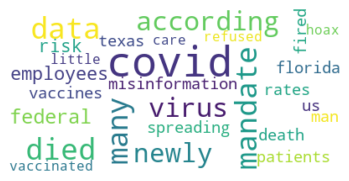

In [110]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate_from_frequencies(neg_word)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")


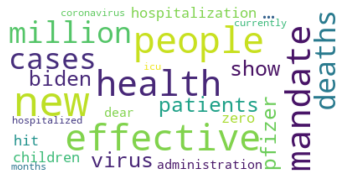

In [111]:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate_from_frequencies(pos_word)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")

plt.show()

In [66]:
mentions_tweets.drop_duplicates(subset=['text'],inplace=True)
mentions_tweets

,original_text,text,urls,mentions,RT,complete_urls,about,sc,tokens,unique
0,@JohnMil80462729 @1am_Adriana @FoxNews Typical...,typically when a report comes out regarding a ...,['https://t.co/cHIR7suctA'],"['@JohnMil80462729', '@1am_Adriana', '@FoxNews']",[],[https://twitter.com/i/web/status/144594161495...,[],0.0000,"[typically, report, comes, regarding, capacity...","[beds…the, capacity, comes, icu, regarding, re..."
1,Despite “news” advertised in past several week...,despite “news” advertised in past several week...,['https://t.co/u0P6lUvgUz'],"['@FoxNews', '@Newsmax']",[],[https://twitter.com/i/web/status/144594097749...,[],0.0000,"[despite, “news”, advertised, past, several, w...","[advertised, despite, fda, included, msm, past..."
2,RT @FoxNews: Hundreds of Michigan healthcare w...,rt hundreds of michigan healthcare workers qui...,['https://t.co/dvG2rIlyIL'],['@FoxNews'],['@FoxNews'],[https://www.foxnews.com/us/mass-exodus-hundre...,[mass exodus hundreds of detroit healthcare wo...,-0.4019,"[hundreds, michigan, healthcare, workers, quit...","[healthcare, hundreds, michigan, quit, refusin..."
3,RT @lpackard: .@FoxNews has undermined vaccine...,rt has undermined vaccines nearly every day o...,[],"['@lpackard', '@FoxNews']",['@lpackard'],[],[],-0.5859,"[undermined, vaccines, nearly, every, day, day...","[day, days, every, kill…, misinformation, mont..."
4,"@FoxNews Who cares, 99% of current covid deat...",who cares of current covid deaths are right ...,[],['@FoxNews'],[],[],[],0.7901,"[cares, current, covid, deaths, right, wingers...","[cares, celebrate, covid, current, deaths, let..."
...,...,...,...,...,...,...,...,...,...,...
36256,RT @WHCOVIDResponse: These findings are backed...,rt these findings are backed up by’s most rece...,[],"['@WHCOVIDResponse', '@CDCGov']",['@WHCOVIDResponse'],[],[],0.0258,"[findings, backed, by’s, recent, national, imm...","[backed, by’s, findings, immunization, nationa..."
36258,A ⁦@CDCgov⁩ study in Arizona “found that schoo...,a ⁦⁩ study in arizona “found that schools that...,['https://t.co/O96tiaNe7F'],['@CDCgov'],[],[https://twitter.com/i/web/status/144460524903...,[],0.0000,"[⁦⁩, study, arizona, “found, schools, require,...","[arizona, masks, require, schools, staff, stud..."
36260,@CDCgov @POTUS STOP PAYING SCHOOLS TO KILL OUR...,stop paying schools to kill our kids with your...,['https://t.co/UuFpYzyKF1'],"['@CDCgov', '@POTUS']",[],[https://twitter.com/MSmiles050/status/1444602...,[],-0.9115,"[stop, paying, schools, kill, kids, covid, man...","[covid, kids, kill, madness, mandates, paying,..."
36261,RT @d4serenity: Wow just a month ago people we...,rt wow just a month ago people were censored s...,[],"['@d4serenity', '@CDCgov']",['@d4serenity'],[],[],-0.5399,"[wow, month, ago, people, censored, suspended,...","[ago, banned, bigtech, censored, director, eve..."


## Leaning and Inclination

In [7]:
import numpy as nt
import os, csv, nltk, lda
import pandas as pd
import numpy as np
from nltk.tokenize import PunktSentenceTokenizer, RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from scipy import sparse
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

from nltk.tokenize import PunktSentenceTokenizer,RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Shivarjun\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Shivarjun\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Shivarjun\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [8]:
tweets_list = mentions_tweets['text'].tolist()

for i in range(0,len(tweets_list)):
    tweets_list[i] = str(tweets_list[i])
mentions_tweets['text'] = tweets_list

In [9]:
ntopics = 10
word_tokenizer=RegexpTokenizer(r'\w+')
wordnet_lemmatizer = WordNetLemmatizer()
stopwords_nltk=set(stopwords.words('english'))

def tokenize_text(version_desc):
    lowercase=version_desc.lower()
    text = wordnet_lemmatizer.lemmatize(lowercase)
    tokens = word_tokenizer.tokenize(text)
    return tokens

vec_words = CountVectorizer(tokenizer=tokenize_text,stop_words=stop,decode_error='ignore')
total_features_words = vec_words.fit_transform(mentions_tweets['text'])

print(total_features_words.shape)

model = lda.LDA(n_topics=int(ntopics), n_iter=500, random_state=1)
model.fit(total_features_words)

topic_word = model.topic_word_
doc_topic = model.doc_topic_
doc_topic = pd.DataFrame(doc_topic)

mentions_tweets=mentions_tweets.join(doc_topic)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['doe', 'ha', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
INFO:lda:n_documents: 11258
INFO:lda:vocab_size: 13271
INFO:lda:n_words: 90659
INFO:lda:n_topics: 10
INFO:lda:n_iter: 500


(11258, 13271)


INFO:lda:<0> log likelihood: -1133241
INFO:lda:<10> log likelihood: -829156
INFO:lda:<20> log likelihood: -812937
INFO:lda:<30> log likelihood: -804129
INFO:lda:<40> log likelihood: -799588
INFO:lda:<50> log likelihood: -796411
INFO:lda:<60> log likelihood: -794070
INFO:lda:<70> log likelihood: -792010
INFO:lda:<80> log likelihood: -789764
INFO:lda:<90> log likelihood: -789451
INFO:lda:<100> log likelihood: -788172
INFO:lda:<110> log likelihood: -787003
INFO:lda:<120> log likelihood: -786071
INFO:lda:<130> log likelihood: -785252
INFO:lda:<140> log likelihood: -784537
INFO:lda:<150> log likelihood: -784360
INFO:lda:<160> log likelihood: -784109
INFO:lda:<170> log likelihood: -783184
INFO:lda:<180> log likelihood: -782953
INFO:lda:<190> log likelihood: -782668
INFO:lda:<200> log likelihood: -782602
INFO:lda:<210> log likelihood: -781990
INFO:lda:<220> log likelihood: -781930
INFO:lda:<230> log likelihood: -781263
INFO:lda:<240> log likelihood: -780969
INFO:lda:<250> log likelihood: -781

In [10]:
tweets=pd.DataFrame()

for i in range(int(ntopics)):
    topic="topic_"+str(i)
    tweets[topic]=mentions_tweets.groupby(['text'])[i].mean()

tweets=tweets.reset_index()
topics=pd.DataFrame(topic_word)
topics.columns=vec_words.get_feature_names()
topics1=topics.transpose()
print ("Topics word distribution written in file topic_word_dist.xlsx ")
topics1.to_excel("topic_word_dist.xlsx")
tweets.to_excel("document_topic_dist.xlsx",index=False)
print ("Document topic distribution written in file document_topic_dist.xlsx ")

Topics word distribution written in file topic_word_dist.xlsx 
Document topic distribution written in file document_topic_dist.xlsx 


In [11]:
tweets.dropna(how='any',inplace=True)
tweets.sort_values('topic_0',ascending=False)

,text,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
9199,there was no covid in january,0.930769,0.007692,0.007692,0.007692,0.007692,0.007692,0.007692,0.007692,0.007692,0.007692
889,and the most outrageous part is that democrats...,0.930769,0.007692,0.007692,0.007692,0.007692,0.007692,0.007692,0.007692,0.007692,0.007692
1111,at p m colorado time my sister past away from...,0.930769,0.007692,0.007692,0.007692,0.007692,0.007692,0.007692,0.007692,0.007692,0.007692
5407,ny healthcare worker vaccination rates rise af...,0.925000,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
3904,in cooperation with the joint artificial intel...,0.925000,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
...,...,...,...,...,...,...,...,...,...,...,...
4563,let me know when the supreme court rules that ...,0.006250,0.193750,0.006250,0.006250,0.193750,0.006250,0.381250,0.068750,0.006250,0.131250
8954,the people who are suffering are statistically...,0.006250,0.006250,0.006250,0.006250,0.006250,0.006250,0.318750,0.443750,0.193750,0.006250
6999,rt the mandate to get healthcare workers in ne...,0.005882,0.064706,0.005882,0.005882,0.005882,0.005882,0.535294,0.005882,0.358824,0.005882
7980,secure the border return the covid infested i...,0.005882,0.005882,0.005882,0.005882,0.005882,0.005882,0.947059,0.005882,0.005882,0.005882


In [12]:
tweets['topic'] = tweets.iloc[:, 1:].T.apply(lambda x: x.idxmax()[-1:])

In [13]:
tweets[tweets['topic']=='2']

,text,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic
14,but yetbelieves that covid mitigation and pr…,0.010000,0.010000,0.910000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,2
24,is stealing our children it’s going to disap...,0.016667,0.016667,0.850000,0.016667,0.016667,0.016667,0.016667,0.016667,0.016667,0.016667,2
34,usa deaths in one year months,0.009091,0.009091,0.281818,0.190909,0.009091,0.009091,0.281818,0.009091,0.190909,0.009091,2
73,as for the revenue numbers is the only actu...,0.011111,0.122222,0.344444,0.011111,0.011111,0.011111,0.344444,0.011111,0.011111,0.122222,2
134,deaths surpassed thanks to bidens super spr...,0.014286,0.014286,0.728571,0.014286,0.014286,0.014286,0.014286,0.014286,0.014286,0.157143,2
...,...,...,...,...,...,...,...,...,...,...,...,...
11074,‘bridgerton’ emmy winner marc pilcher dead at ...,0.025000,0.025000,0.525000,0.025000,0.025000,0.025000,0.025000,0.275000,0.025000,0.025000,2
11097,“doctors are angry with my denial misinformat...,0.161538,0.007692,0.238462,0.007692,0.007692,0.238462,0.007692,0.007692,0.161538,0.161538,2
11134,•revealed leader of group peddling bleach as c...,0.007692,0.238462,0.700000,0.007692,0.007692,0.007692,0.007692,0.007692,0.007692,0.007692,2
11149,⁦⁩ ⁦⁩ ⁦⁩ the truth is there has been a lot of ...,0.011111,0.011111,0.900000,0.011111,0.011111,0.011111,0.011111,0.011111,0.011111,0.011111,2


In [14]:
def Lift(Word1,Word2, df):
    CountA  = sum(df['text'].str.contains(Word1))
    CountB  = sum(df['text'].str.contains(Word2))
    CountAB = sum(df['text'].str.contains(Word1) & df['text'].str.contains(Word2))

    '''
    MaskA   = tweets['unique'].map(lambda x: True if Word1 in x else False)
    MaskB   = tweets['unique'].map(lambda x: True if Word2 in x else False)
    CountA  = sum(MaskA)
    CountB  = sum(MaskB)
    CountAB = sum(MaskA & MaskB)
    '''
    N       = len(df)
    return (N * CountAB)/max(CountA * CountB,0)


def CondLift(Word1,Word2,Word3,df):
    
    CountABC = sum(df['text'].str.contains(Word1) & df['text'].str.contains(Word2) & df['text'].str.contains(Word3))
    CountC   = sum(df['text'].str.contains(Word3))
    
    CountAC  = sum(df['text'].str.contains(Word1) & df['text'].str.contains(Word3))
    CountBC  = sum(df['text'].str.contains(Word2) & df['text'].str.contains(Word3))
    
    '''
    MaskA   = tweets['unique'].map(lambda x: True if Word1 in x else False)
    MaskB   = tweets['unique'].map(lambda x: True if Word2 in x else False)
    CountA  = sum(MaskA)
    CountB  = sum(MaskB)
    CountAB = sum(MaskA & MaskB)
    '''
    return (CountC * CountABC)/(CountAC * CountBC)

Lift("virus","made", tweets[tweets['topic']=='4'])
#CondLift("approved","effective","", tweets)#[tweets['topic']=='9'])

0.0

In [15]:
#tweets[tweets['text'].str.contains('florida')]
display(tweets.loc[tweets['topic']=='5','text'])

64        and again what year did we authorize a bunch ...
83        biden report cardf  put us citizens first f  ...
87        billion people have had at least one covid va...
170       how many deaths are due to the spread of vacc...
341       people either died with covid or from covid t...
                               ...                        
11130    “with covid” does not mean “of covid” your pro...
11138    … and his view is more important than any othe...
11233    🙄❄️❄️❄️days before the supreme court is set to...
11238    🙄❄️❄️❄️stephanie grisham former trump press se...
11247    🤣 you’re just gonna keep spreading this garbag...
Name: text, Length: 307, dtype: object

In [16]:
tweets.groupby('topic')['text'].count()

topic
0    404
1    277
2    313
3    277
4    343
5    307
6    281
7    467
8    476
9    254
Name: text, dtype: int64

In [17]:
lift_df = pd.DataFrame(columns=['topic','word1','word2','lift'])

for i in range(0,10):
    topic_word = list(topics1.sort_values(by=i,ascending=False).index[:10]) 
    try:
        for word1 in topic_word:
            for word2 in topic_word:
                if word1!=word2:
                    lift_df.loc[len(lift_df)] = [i,word1,word2,Lift(word1,word2,tweets[tweets['topic']==str(i)])]
    except:
        print(word1,word2,topic)

news countries topic_9
covid false topic_9
covid pregnant topic_9


In [18]:
lift_df

,topic,word1,word2,lift
0,0,covid,year,0.898177
1,0,covid,last,1.751445
2,0,covid,died,1.868208
3,0,covid,like,0.817341
4,0,covid,read,0.808359
...,...,...,...,...
645,9,dont,effects,0.000000
646,9,dont,patients,8.466667
647,9,dont,need,3.175000
648,9,dont,people,1.154545


In [19]:
lift_df[lift_df['topic']==9].sort_values('lift',ascending=False)[:50]
#lift_df.groupby('topic')['lift'].cumcount()

,topic,word1,word2,lift
597,9,effects,long,127.000000
572,9,long,effects,127.000000
619,9,need,patients,10.583333
610,9,patients,need,10.583333
613,9,patients,dont,8.466667
646,9,dont,patients,8.466667
571,9,long,vaccine,6.864865
580,9,vaccines,vaccine,6.864865
588,9,vaccine,long,6.864865
589,9,vaccine,vaccines,6.864865


In [20]:
#lift_df.groupby("topic")['word2','word1','lift'].nlargest(2)#.sort_values('lift',ascending=False)
lift_df[lift_df['topic']==0].sort_values('lift',ascending=False).head(50)

,topic,word1,word2,lift
11,0,year,died,9.323077
28,0,died,year,9.323077
41,0,like,said,5.050000
58,0,said,like,5.050000
26,0,last,flu,4.809524
83,0,flu,last,4.809524
34,0,died,people,4.661538
75,0,people,died,4.661538
17,0,year,flu,4.439560
89,0,flu,people,4.439560


In [21]:
topics1#.sort_values(by=['0'])

,0,1,2,3,4,5,6,7,8,9
aaaannd,0.000001,0.000001,0.000127,0.000001,0.000001,0.000001,0.000001,9.130994e-07,8.263978e-07,0.000001
aanalysis,0.000001,0.000001,0.000252,0.000001,0.000001,0.000001,0.000001,9.130994e-07,8.263978e-07,0.000001
aaron,0.000001,0.000001,0.000127,0.000001,0.000001,0.000001,0.000001,9.130994e-07,8.263978e-07,0.000001
aasld,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,9.130994e-07,8.263978e-07,0.000125
ab,0.000001,0.000751,0.000001,0.000001,0.000001,0.000001,0.000001,9.130994e-07,4.140253e-04,0.000001
...,...,...,...,...,...,...,...,...,...,...
公支,0.000001,0.000001,0.000001,0.000001,0.000104,0.000001,0.000001,9.130994e-07,8.263978e-07,0.000001
英会話,0.000001,0.000001,0.000127,0.000001,0.000001,0.000001,0.000001,9.130994e-07,8.263978e-07,0.000001
英検,0.000001,0.000001,0.000001,0.000001,0.000001,0.000105,0.000001,9.130994e-07,8.263978e-07,0.000001
英語,0.000001,0.000001,0.000127,0.000001,0.000001,0.000001,0.000001,9.130994e-07,8.263978e-07,0.000001


In [22]:
lift_df.groupby('topic')['lift'].head(5)

0       0.898177
1       1.751445
2       1.868208
3       0.817341
4       0.808359
90      0.446294
91     13.190476
92      6.595238
93      1.236607
94      1.798701
97      0.276014
98      0.603781
99      1.159259
100     1.081975
101     0.000000
103     0.982270
104     5.893617
105     0.000000
106     2.946809
107     1.964539
193     1.231282
194     1.646400
195     0.653333
196     0.914667
197     0.800333
200     1.530627
201     0.000000
202     1.311966
203     1.039254
204     1.967949
290     1.057596
291     0.372926
292     1.076825
293     0.932316
294     0.598236
380     1.014180
381     1.151487
382     1.079519
383     0.781721
384     2.015102
470     1.055965
471     1.345639
472     0.751975
473     1.093781
474     1.341360
560     1.840580
561     0.566332
562     0.945163
563     1.840580
564     0.613527
Name: lift, dtype: float64

In [23]:
tweets['sc'] = tweets['text'].apply(lambda review: sid.polarity_scores(review)['compound'])

In [24]:
tweets.groupby('topic')['sc'].mean()

topic
0   -0.053078
1   -0.039337
2   -0.040518
3   -0.088212
4   -0.070785
5   -0.069664
6   -0.066500
7   -0.059486
8   -0.040246
9   -0.036556
Name: sc, dtype: float64

In [25]:
tweets[tweets['sc']>0].groupby('topic')['text'].count()

topic
0    123
1     98
2    102
3     73
4    103
5     97
6     97
7    135
8    156
9     89
Name: text, dtype: int64

In [26]:
temp = tweets[tweets['topic']=='2']
temp = temp[temp['text'].str.contains('mandate') & temp['text'].str.contains('work')]
temp['sc'].mean()

0.6486

In [27]:
tweets

,text,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic,sc
5,more evidence that this was all…,0.011111,0.011111,0.122222,0.122222,0.122222,0.011111,0.011111,0.011111,0.566667,0.011111,8,0.0000
9,deaths in usa in year and months,0.014286,0.157143,0.157143,0.442857,0.014286,0.014286,0.157143,0.014286,0.014286,0.014286,3,0.0000
10,deaths in usa in year and mon…,0.310000,0.010000,0.010000,0.110000,0.010000,0.010000,0.210000,0.010000,0.310000,0.010000,0,0.0000
14,but yetbelieves that covid mitigation and pr…,0.010000,0.010000,0.910000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,2,0.0000
15,but yetbelieves that covid mitigation and…,0.016667,0.016667,0.016667,0.016667,0.016667,0.016667,0.016667,0.850000,0.016667,0.016667,7,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11242,🚨senator ron johnson launders coronavirus cons...,0.011111,0.011111,0.011111,0.011111,0.788889,0.011111,0.122222,0.011111,0.011111,0.011111,4,-0.5267
11247,🤣 you’re just gonna keep spreading this garbag...,0.009091,0.009091,0.009091,0.009091,0.009091,0.918182,0.009091,0.009091,0.009091,0.009091,5,0.0000
11248,🤣🤣🤣 have you heard of a small company calledth...,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.700000,0.033333,8,0.0000
11249,🤣🤣🤣 of course fox doesn’t report that this dr ...,0.007143,0.007143,0.007143,0.078571,0.435714,0.007143,0.007143,0.221429,0.078571,0.150000,4,0.0000


In [28]:
mentions_tweets.loc[mentions_tweets['text'].str.contains('pregnant') & mentions_tweets['text'].str.contains('vac'),'text']#.mean()

7632     i dont care if you get pregnant or get vaccina...
7646     cdc gets blowback for urging pregnant people t...
7701     rt a new push by the cdc for pregnant people t...
9332     new cdc advisory urges vaccination for pregnan...
11725    the cdc has said to wash your hands so as to n...
13386    as reports of deaths after covid vaccines near...
19256    rt the cdc has issued an urgent recommendation...
21224    rt the cdc is urging pregnant women to get the...
29717    rt  vaccines do not cause infertility — and if...
29948    uscalls for more covidvaccines among pregnant ...
30838     vaccines do not cause infertility — and if yo...
31243    so glad i got vaccinated while pregnant giving...
31341    rt we strongly urge people who are pregnant re...
31494    rt urgent data per  increased risk of death fr...
31594    rt strongly recommends  vaccine before during ...
32007     strongly recommends  vaccine before during or...
32204    rt strongly recommends  vaccine before during .

In [29]:
mentions_tweets 

,original_text,text,urls,mentions,RT,complete_urls,about,sc,tokens,unique,0,1,2,3,4,5,6,7,8,9
0,@JohnMil80462729 @1am_Adriana @FoxNews Typical...,typically when a report comes out regarding a ...,['https://t.co/cHIR7suctA'],"['@JohnMil80462729', '@1am_Adriana', '@FoxNews']",[],[https://twitter.com/i/web/status/144594161495...,[],0.0000,"[typically, report, comes, regarding, capacity...","[beds…the, capacity, comes, icu, regarding, re...",0.011111,0.011111,0.566667,0.011111,0.011111,0.011111,0.011111,0.011111,0.011111,0.344444
1,Despite “news” advertised in past several week...,despite “news” advertised in past several week...,['https://t.co/u0P6lUvgUz'],"['@FoxNews', '@Newsmax']",[],[https://twitter.com/i/web/status/144594097749...,[],0.0000,"[despite, “news”, advertised, past, several, w...","[advertised, despite, fda, included, msm, past...",0.009091,0.009091,0.009091,0.918182,0.009091,0.009091,0.009091,0.009091,0.009091,0.009091
2,RT @FoxNews: Hundreds of Michigan healthcare w...,rt hundreds of michigan healthcare workers qui...,['https://t.co/dvG2rIlyIL'],['@FoxNews'],['@FoxNews'],[https://www.foxnews.com/us/mass-exodus-hundre...,[mass exodus hundreds of detroit healthcare wo...,-0.4019,"[hundreds, michigan, healthcare, workers, quit...","[healthcare, hundreds, michigan, quit, refusin...",0.012500,0.012500,0.012500,0.012500,0.012500,0.012500,0.887500,0.012500,0.012500,0.012500
3,RT @lpackard: .@FoxNews has undermined vaccine...,rt has undermined vaccines nearly every day o...,[],"['@lpackard', '@FoxNews']",['@lpackard'],[],[],-0.5859,"[undermined, vaccines, nearly, every, day, day...","[day, days, every, kill…, misinformation, mont...",0.008333,0.091667,0.008333,0.591667,0.008333,0.008333,0.008333,0.008333,0.258333,0.008333
4,"@FoxNews Who cares, 99% of current covid deat...",who cares of current covid deaths are right ...,[],['@FoxNews'],[],[],[],0.7901,"[cares, current, covid, deaths, right, wingers...","[cares, celebrate, covid, current, deaths, let...",0.011111,0.011111,0.788889,0.011111,0.011111,0.011111,0.011111,0.011111,0.122222,0.011111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36256,RT @WHCOVIDResponse: These findings are backed...,rt these findings are backed up by’s most rece...,[],"['@WHCOVIDResponse', '@CDCGov']",['@WHCOVIDResponse'],[],[],0.0258,"[findings, backed, by’s, recent, national, imm...","[backed, by’s, findings, immunization, nationa...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36258,A ⁦@CDCgov⁩ study in Arizona “found that schoo...,a ⁦⁩ study in arizona “found that schools that...,['https://t.co/O96tiaNe7F'],['@CDCgov'],[],[https://twitter.com/i/web/status/144460524903...,[],0.0000,"[⁦⁩, study, arizona, “found, schools, require,...","[arizona, masks, require, schools, staff, stud...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36260,@CDCgov @POTUS STOP PAYING SCHOOLS TO KILL OUR...,stop paying schools to kill our kids with your...,['https://t.co/UuFpYzyKF1'],"['@CDCgov', '@POTUS']",[],[https://twitter.com/MSmiles050/status/1444602...,[],-0.9115,"[stop, paying, schools, kill, kids, covid, man...","[covid, kids, kill, madness, mandates, paying,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36261,RT @d4serenity: Wow just a month ago people we...,rt wow just a month ago people were censored s...,[],"['@d4serenity', '@CDCgov']",['@d4serenity'],[],[],-0.5399,"[wow, month, ago, people, censored, suspended,...","[ago, banned, bigtech, censored, director, eve...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [99]:
def Lift(Word1,Word2, df):
    CountA  = sum(df['original_text'].str.lower().str.contains(Word1))
    CountB  = sum(df['original_text'].str.lower().str.contains(Word2))
    CountAB = sum(df['original_text'].str.lower().str.contains(Word1) & df['original_text'].str.lower().str.contains(Word2))

    '''
    MaskA   = tweets['unique'].map(lambda x: True if Word1 in x else False)
    MaskB   = tweets['unique'].map(lambda x: True if Word2 in x else False)
    CountA  = sum(MaskA)
    CountB  = sum(MaskB)
    CountAB = sum(MaskA & MaskB)
    '''
    
    N       = len(df)
    
    #print(CountA,CountB,CountAB,N)
    
    return (N * CountAB)/max(CountA * CountB,0)

Lift("foxnews","ben",temp )

0.12653482959000012

In [95]:
temp = mentions_tweets[mentions_tweets['original_text'].str.lower().str.contains("cdc") | 
    mentions_tweets['original_text'].str.lower().str.contains("who") |
    mentions_tweets['original_text'].str.lower().str.contains("abc") |
    mentions_tweets['original_text'].str.lower().str.contains("newsmax") |
    mentions_tweets['original_text'].str.lower().str.contains("tucker") |
    mentions_tweets['original_text'].str.lower().str.contains("cnn") |
    mentions_tweets['original_text'].str.lower().str.contains("foxnews") |
    mentions_tweets['original_text'].str.lower().str.contains("bens")]